In [15]:
##### Visual String Pot
# This program takes an image and finds the centre of an orange stripe and green dot. It then use the length of the orange stripe to scale the difference between the clusters to calculate the length.
# it uses FAISS kmeans clustering to find a cluster of the approximate size of the stripe and dot.
# the stripe and dot are then rotated onto the principle component of the stripe
# the user defines a reduction and enchancment factotor which reduces the numbe rof pixcel and enchances the colours when the images are imported.
# the uses then defines the window to focus clustering and the aprox dimensions of the striope and dot
# the results are then exported as a csv with index, fileName, timeStamp, measurement, dotMedian, stripeMedian, scale, dotLength,

In [2]:
#### In version 1.1
# image correction and scaling simplified
# plotting impoved
# hyperparmter entry streamlined
# post calibration, offset and scaling
# improved layout to add option for other clustering methods later

In [3]:
# define functions

def loadImages(directory, file_list, sample, reduction, enchanced, dim, ench_type):
    ## Function takes file list and  if samples --> loads sample,
    # otherwise loads all images in file list, reducing by the reduction factor and enchancing by the enchance factor.
    # If dim --> crops image otherwise entire image is loaded

    timeStamp = []  # create empty list for time stamps
    index = 0  # set index to zero, used as counter for assignment  to array

    if not sample:  # if sample does not exist create a list of numbers to load
        sample = range(len(file_list))  # make sample the entire file list

    if not dim:  # open an image and get the image dimensions if no cropping is supplied
        image = np.array(Image.open(directory + file_list[0]).reduce(int((reduction))))  # load image to array
        h, w, d = tuple(image.shape)  # get shape of image in file
        dim = [0, h, 0, w, ]  # assign shape to dim list so entire image is imported

    # Create empty NP array for pixcels. All pictures are loaded into an array height, width, # images, colours
    pixcels = np.empty((dim[1] - dim[0],  # number of rows
                        dim[3] - dim[2],  # number of columns
                        len(sample),  # number of images
                        3),  # number of colour arrays per image + 3 for x and y and l
                       dtype='float32') # set data type as float 32 for faiss

    for sam in sample:  # loop over each file in file_list
        clear_output(wait=True)  # clear output
        file = file_list[sam]  # set file as the sam'th entry in file list
        file_path = directory + file  # define file path
        ts = Image.open(file_path)._getexif()[36867]  # import timestamp as tS

        if enchanced:  # if an enchancments is call
            #open image and create enchancer
            if ench_type == 'Bright':
                enchancer = ImageEnhance.Brightness(Image.open(file_path).reduce(int((reduction))))
                image = np.array(enchancer.enhance(enchanced))  # load image and convert to array

            else:
                enchancer = ImageEnhance.Contrast(Image.open(file_path).reduce(int((reduction))))
                image = np.array(enchancer.enhance(enchanced))  # load image and convert to array

        else:  # if no enchancement is called
            image = np.array(Image.open(file_path).reduce(int((reduction))))  # load image into array

        # crop array and load into pixcels array
        pixcels[:, :, index, :] = image[dim[0]: dim[1],
                                  dim[2]: dim[3],
                                  :]

        timeStamp.append(ts)  # append time stamp to list
        index += 1 # increase index counter by 1
        print("importing " + file + " file # " + str(sam + 1) + " of " + str(len(file_list) + 1)) # print file number
        print(ts) # print time stamp
    return (timeStamp, pixcels)

def determine_enchancement(in_dir, file_list, sample, reduction, enchancement, dim, ench_type, target_length):
    ## Define function determines how much brightening is required for the provided subset.

    avgLength = 0 # set avgLength variable as 0 to enter while loop
    while avgLength < target_length: # continue to increase brightening while avgLength is less than target length
        timeStamp, pixcels = loadImages(in_dir, file_list, sample, reduction, enchancement, dim, ench_type) # load target sample
        avgLength = np.reshape(pixcels, (-1,3)) # reshape pixcels to just rgb from all images
        lengths = [] # create empty list to append length to
        for i in range(0,avgLength.shape[0]): # iterate over each pixcel and calculate the length
            lengths.append(np.linalg.norm(avgLength[i])) # append pixcel length to the avgLength list
        avgLength = sum(lengths)/len(lengths) # calulate overall average length

        if avgLength < target_length: # if avg length is not large enough increace enchacemnt by 1
            enchancement += 1

    return enchancement

def clus2Image(clussArr, centers, recolour_dict, scale):
    ## define function to take an array of cluster labels and centers and return an image array, with specified clusters recoulured if required
    if scale:
        Scaler = MinMaxScaler(feature_range=(0,255)) # define minmax scaler to scale colours to 0 --> 255
        centers = Scaler.fit_transform(centers)

    if recolour_dict: # if recolour provided
        for key in recolour_dict.keys(): # iterate over each key value pair
            centers[key] = np.asarray(recolour_dict[key]) # change the value of that center to the specified colour

    imgArr = centers[clussArr]

    return(imgArr)

def plotSamples(imgArray, ticks, title, titleData, scaleColours):
    ## function image array and if required scales pixcel to 0-255
    # Then plots images over 2 columns and as many rows as required. user selects if ticks and headings --> supply heading data in list form

    if scaleColours: # if scaling colours is required
        Scaler = MinMaxScaler(feature_range=(0,255)) # define minmax scaller to scale colours to 0 --> 255
        imgArray = Scaler.fit_transform(imgArray) # scale image array RGB channels


    sampleSize = imgArray.shape[2]  # return the 3rd dimension of the array as the number of images to plot
    width = 2  # set number of columns to plot
    height = int(sampleSize / width)  # determine how many rows to plot
    index = 0  # set a counter to 0
    plt.close()  # close previous plot
    f, axarr = plt.subplots(height, width)  # create enough rows to plot all samples
    for row in range(0, height):  # iterate over each image row
        for h in range(0, height):  # iterare over each column
            axarr[h, row].imshow(imgArray[:, :, index, :].astype('uint8'))  # open image and plot
            if title:
                axarr[h, row].title.set_text(titleData[row])

            if not ticks:
                axarr[h, row].set_xticks([])
                axarr[h, row].set_yticks([])

            index += 1  # increase counter by 1

def faissCluster(pixcels, frac, startClus, noIt, reduction):
    ## define function to perfrom kmeans clustering using faiss
    no_clusters = startClus  # set inital number of clusters
    no_iterations = noIt  # set the no of iterations for each step of kmeans
    clusterMin = 1000  # set cluster min to enter while loop
    restart = 0
    pixcels = np.reshape(pixcels, (h*w*l,-1)) # reshape pixcels to a list of features
    d = pixcels.shape[1] # record the length of each feature to for faiss clustering definition

    if pixcels.dtype != 'float32': # check pixcel data type is suitable for faiss
        pixcels = pixcels.astype('float32') # if required change data type
        print("input array data type changed to "+str(pixcels.dtype)) # print conformation that data type change

    while clusterMin > frac:  # continue to increase number of clusters until the smallest cluster becomes sufficently small to just be the stripe
        #clear_output(wait=True)  # clear output
        print('clustering with ' + str(no_clusters) + "\n")
        kmeans = faiss.Kmeans(d, no_clusters, niter=no_iterations, verbose=True)  # define faiss kmeans object
        kmeans.train(pixcels)  # train kmeans object
        D, I = kmeans.index.search(pixcels, 1)  # return kmeans
        pixInClus = np.unique(I, return_counts=True)  # get counts # pixels in each cluster
        #colour = np.where(pixInClus[1] == min(pixInClus[1])) # assigns the smallest cluster as the stripe colour
        colour = np.where(
            abs(pixInClus[1] / pixInClus[1].sum() - frac) == abs(pixInClus[1] / pixInClus[1].sum() - frac).min())
        clusterMin = min(pixInClus[1]) / (
                    h * w * l)  # Calcultes the fraction of the picture occupied the the stripeColour
        no_clusters += 1  # Increase number of clusters by 1

        if clusterMin < 0.5 * frac: # check if cluster min is signifigantly smaller than the expected fraction
            frac = 1.15 * frac # increase fraction so clustering stops slightly earlier to stop the last step being too large
            no_clusters = startClus # restart the number of clusters
            clusterMin = 1000 # restart cluster min to restart while loop

        print("Cluster Min was " + str(clusterMin) + "\n") # print what the cluster min was

    I = np.reshape(I, (h,w,l,1))

    return (I, kmeans, colour[0])

def get_colour_cosine(kmeans, target_colour):
    ## define function to inspect all cluster centers and determine which has the closest cosine distance to the target colour

    cosineDistance = [] # empty list to store cosine distances

    for i in range(0,kmeans.centroids.shape[0]): # iterate over each centroid
        cosineDistance.append(distance.cosine(kmeans.centroids[i,:], target_colour)) # append the cosine distance to target colour

    trgCluster = np.where(cosineDistance == min(cosineDistance)) # find the closest
    trgCluster = trgCluster[0] # return single row of array for easy handling

    return trgCluster

def norm_to_target(labels, imgArray, trgClus, trg):
    ## Define function to normalise each image so as the target clusters appear similar for each image

    noStripe = 0 # set number of images not containing a pixcel clustered to the stripe colour

    imgArray = np.reshape(imgArray,(-1,l,3), order='F') # reshape fortran style so as each photo is a list of vectors

    ## find stripe mean and the picture mean
    if trg: # if normalising based on stripe colour
        labels = np.reshape(labels,(-1,l), order='F') # reshape labels fortran style so as each image is a list of labels
        picMeans_orig = [] # create empty list to append each picture mean
        for i in range(0,l): # iterate over each picture
            if np.where(labels[:,i] == trgClus)[0].shape[0] > 10: # check image contains atleast 10 stripe pixcels
                picMean = list(imgArray[np.where(labels[:,i] == trgClus),i,:].mean(axis=0)[0]) # calculate the mean value of the pixcels that are in stripe
                picMeans_orig.append(picMean) # append this mean to pic mean

            else: # if no stripe pixcels are found append the avergae of the previous photo
                picMeans_orig.append(picMean)
                print("used Last pic mean "+str(picMean)+" for image number "+str(i))
                noStripe +=1

        picMeans_orig = np.array(picMeans_orig) # make picMeans_orig an array
        stripe_mean = picMeans_orig.mean(axis=0) # calculate stripe means by finding the average of pic means
        meanModifer = np.subtract(np.transpose(np.reshape(np.tile(stripe_mean, l),(3,l), order='F')),picMeans_orig) # determine the mean modifier

        for i in range(0,l): # iterate over each image
            imgArray[:,i,:] = np.transpose(np.transpose(imgArray[:,i,:])+np.reshape(np.repeat(meanModifer[i,:], h*w, axis=0), (d,h*w))) # apply the mean modifier

    imgArray[np.where(imgArray < 0)] = 0 # find anywhere the the rgb has gone below 0 and replace with 0
    imgArray = np.reshape(imgArray,(h*w*l,d)) # reshape img array to list of pixcels
    pixcelSums = imgArray.sum(axis=1) # find the sum of each pixcel
    pixcelSums[np.where(pixcelSums == 0)] = 1 # where the pixcel sum is 0 replace with 1 to avoid dev by 0 error, it wont matter as 0/1 = 0
    pixcelSums = np.reshape(np.tile(pixcelSums,3), (h*w*l,d), order='F') # reshape to correct shape
    imgArray = np.divide(imgArray, pixcelSums) # normalise by dividing by sum
    imgArray = np.reshape(np.reshape(imgArray,(h*w,l,d)), (h,w,l,d), order='F') # reshape to hand back to

    return imgArray, noStripe

def cleanIQR(upper, lower, singleValues, inplace, verb):
    iqr = np.subtract(*np.percentile(singleValues, [75, 25])) # calculate the interquartile range
    minus = np.percentile(singleValues, 25) - lower * iqr # calculate the lower bound as lower x iqr from the 25th percentile
    plus = np.percentile(singleValues, 75) + upper * iqr # calculate the upper bound as upper x iqr from the 75th percentile
    toKeep = (minus < singleValues) & (singleValues < plus) # create list of logicals defining which values to keep
    if verb: # if verb create box plots
        plt.close()
        f, axarr = plt.subplots(2)  # create enough rows to plot all samples
        axarr[0].boxplot(singleValues)
        axarr[1].boxplot(singleValues[(minus < singleValues) & (singleValues < plus)])
        print('The min projected y value before cleaning is ' + str(singleValues.min()))
        print('The max projected y value before cleaning is ' + str(singleValues.max()))
        print('The min projected y value after cleaning is ' +
              str(singleValues[(minus < singleValues) & (singleValues < plus)].min()))
        print('The max projected y value after cleaning is ' +
              str(singleValues[(minus < singleValues) & (singleValues < plus)].max()))

    if inplace: # if inplace return the vales to keep only
        return (singleValues[(minus < singleValues) & (singleValues < plus)])
    else: # otherwsie return the logical list for filtering out of this function
        return (toKeep)

def find_rotation(coords):
    # define the IQR range to use when cleaning values prior to calculating rotation matrix
    perpClean_min = 1.5 # IQR to use to filter perpendicular to stripe
    perpClean_max = 1.5
    rotClean_min = 1.5 # IQR to use to filter values along the stripe
    rotClean_max = 1.5
    n=0
    while n < 2: # repeat twice so as outliers to not affect the rotation matrix
        pca = PCA(2) #define pca
        pca.fit(coords[0:2,:].T) # fit pca to the stripe cordinates
        Vh = pca.components_ # find rotation vector
        stripe_perp = coords[0:2,:].T @ Vh[:,1] # rotate stripe onto second principle component of stripe to clean
        stripe_perp = cleanIQR(perpClean_max,perpClean_min,stripe_perp, False, True) # remove outliers from stripe rot
        stripe_rot = coords[0:2,:].T @ Vh[:,0] # rotate stripe onto first principle component
        stripe_rot = stripe_rot[stripe_perp]
        coords = coords[:, stripe_perp]
        stripe_rot = cleanIQR(rotClean_max,rotClean_min,stripe_rot, False, True) # clean IQR
        coords = coords[:,stripe_rot]
        n += 1 # increase counter by 1

    print("Stripe is roated "+str(math.acos(Vh[0,0]))+" degrees")
    return(Vh, coords)

def cluster_length(coordinates, Vh):
    ## Define function to find the length of clustered pixcels along the principle component.
    imgNo = []
    start_list = []
    stop_list = []
    length_list = []
    prob_list = []
    start_grad = []
    stop_grad = []
    fail = []
    for i in range(0,l):
        clear_output(wait=True)
        print("calculating cluster length for image #"+str(i)+"of"+str(l))
        try:
            
            pic = coordinates[0:2,np.where(coordinates[2,:] == i)[0]] # select from single photo
            pic = np.transpose(np.matmul(np.transpose(pic), Vh)) # transpose and mulitiply by rotation matrix
            pic = abs(np.rint(pic[0,:]).astype('int')) # round and multiply by negative 1
            count = np.bincount(pic) # count how many occourences for each x value
            start = np.where(np.diff(count) == np.diff(count).max())[0][0]
            stop = np.where(np.diff(count) == np.diff(count).min())[0][0]
            length = stop - start
            m = count.max() # assume the highest count is actually the full stripe
            prob = count / m # calculate the probability of each x observation actually being a stripe
            stripeProb = prob[start:stop].sum()/len(prob[start:stop])
            
            start_list.append(start)
            stop_list.append(stop)
            prob_list.append(stripeProb)
            length_list.append(length)
            start_grad.append(np.diff(count)[np.where(np.diff(count) == np.diff(count).max())[0][0]])
            stop_grad.append(np.diff(count)[np.where(np.diff(count) == np.diff(count).min())[0][0]])
            imgNo.append(i)

        except:
            start_list.append(float("nan"))
            stop_list.append(float("nan"))
            prob_list.append(float("nan"))
            length_list.append(float("nan"))
            start_grad.append(float("nan"))
            stop_grad.append(float("nan"))
            imgNo.append(i)
            
    percentileLimit = np.nanpercentile(np.array(prob_list), 95)
    goodSample = np.where(np.array(prob_list) > percentileLimit)
    lengths = np.asarray(length_list)
    clusLength = np.median(lengths[goodSample])

    Stats_df = pd.DataFrame({'image': imgNo,
                             'start': start_list,
                             'stop': stop_list,
                             'length': length_list,
                             'probability': prob_list,
                             'startGrad': start_grad,
                             'stopGrad': stop_grad})
    
    return Stats_df, clusLength

def getMiddle(stats_df, length, label):
    length_logical = stats_df.length > 0.9 * length
    probs_logical = stats_df.probability > 0.9
    start_logical = abs(stats_df.startGrad) / abs(stats_df.stopGrad) > 0.75
    stop_logical = abs(stats_df.stopGrad) / abs(stats_df.startGrad) > 0.75
    stats_df['useMean'] = list(map(all, zip(length_logical,probs_logical, start_logical, stop_logical)))
    mid = []
    for index, row in stats_df.iterrows():
        if row['useMean']:
            mid.append((row['start']+row['stop'])/2)
        else:
            if abs(row['startGrad']) > abs(row['stopGrad']):
                mid.append(row['start']+ 0.5 * length)
            else:
                mid.append(row['stop']- 0.5 * length)

    stats_df[label] = mid
    
    return(stats_df)


In [4]:
## Import packages
import time
import faiss
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook

from IPython.display import clear_output
from os import listdir
from os.path import isfile, join
from PIL import Image, ImageEnhance

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from scipy.spatial import distance
from scipy.fft import fft, fftfreq, ifft


In [5]:
## define working directory and which files to sample
in_dir = '/mnt/veeringDL_storage/test_2/' # define directory containing all gopro images
out_dir = '/mnt/home/9.0 Data Jobs/' # define output directory
file_list = [f for f in listdir(in_dir) if isfile(join(in_dir, f))] # inspect directory and return list of files
print(str(len(file_list))+' Images found in folder')

5306 Images found in folder


In [6]:
## user defines which images to sample, trget size, enchancemt factor and type
sample = [50,1000,3000,4500] # Set which 4 images to sample
## make this a fraction of gopro ??
targetSize = 1200000 # define target size in pixcels
enchancement = 1 # define enchancement value
ench_type = 'Bright' # define enchancement type

importing G0032199.JPG file # 4501 of 5307
2022:04:06 16:58:00


<IPython.core.display.Javascript object>


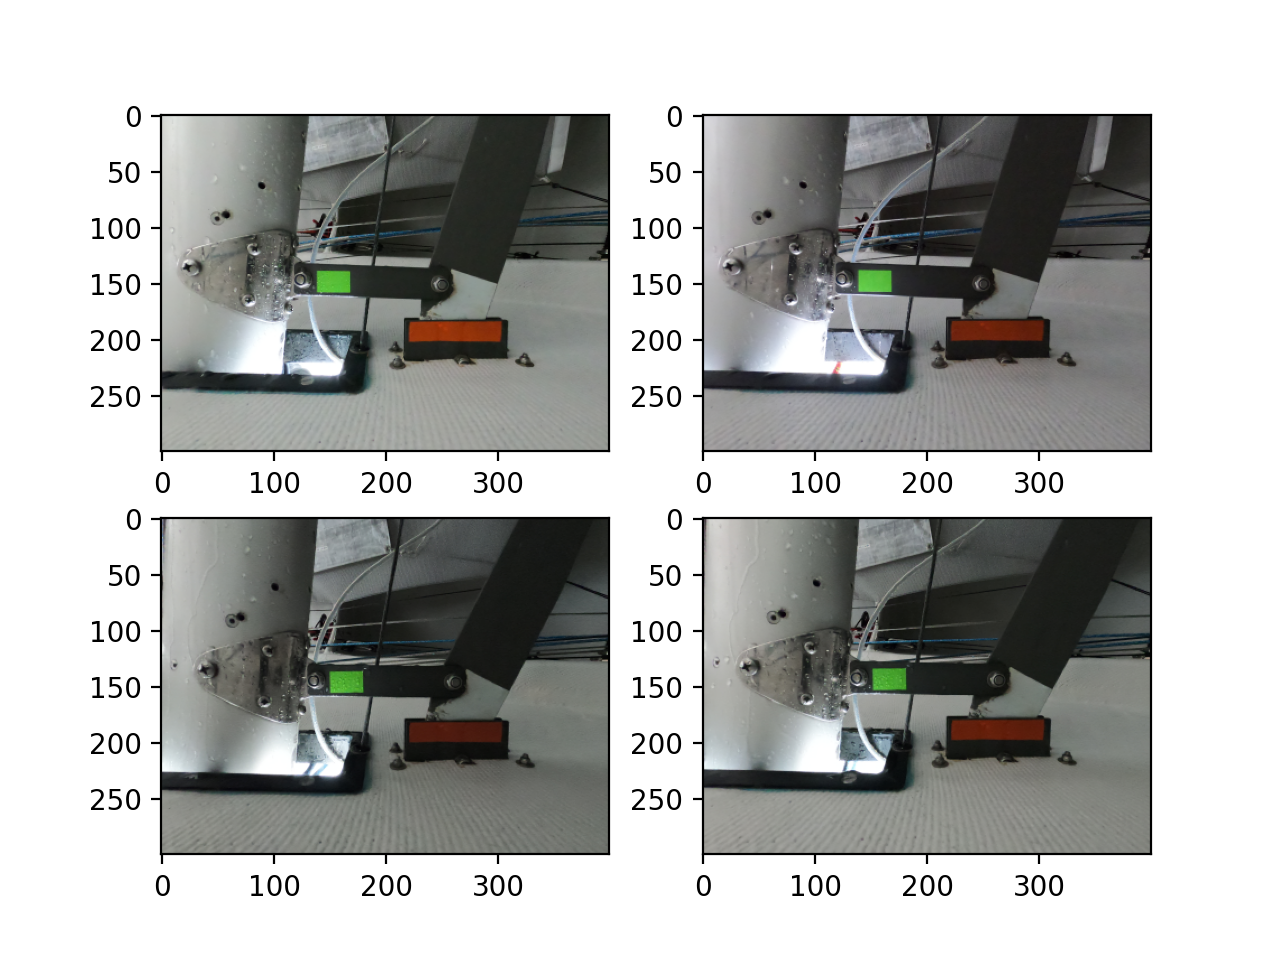

In [7]:
## load sample images and plot
timeStamp, pixcels = loadImages(in_dir, file_list, [0], 1, False, False, False) # load a single image at full resolution
h, w, l, d = orig_shape = tuple(pixcels.shape) # return the dimensions of the original image
reduction = int((h*w)/targetSize) # caclulate the required reduction
print('A reduction factor of '+str(reduction)+' was adopted')
timeStamp, pixcels = loadImages(in_dir, file_list, sample, reduction, enchancement, False, ench_type)
plotSamples(pixcels, True, False, False, False)

importing G0032199.JPG file # 4501 of 5307
2022:04:06 16:58:00
Brightness used 2


<IPython.core.display.Javascript object>


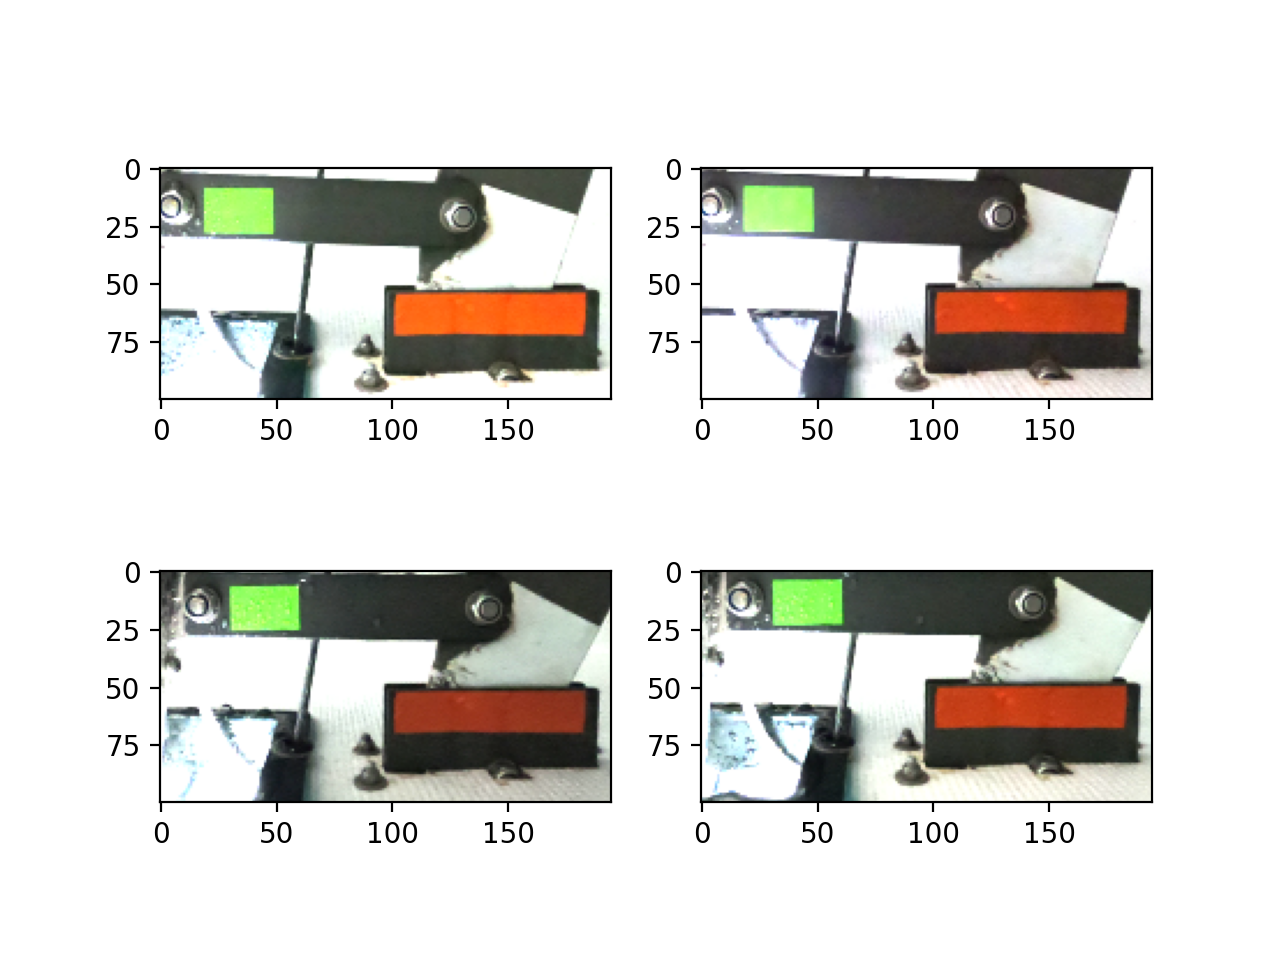

In [8]:
## User defines where to crop image
h1 = 120 # horizontal (x) to start image at
h2 = 315 # horizontal (x) to end image at
v1 = 130 # vertical (y) to start image at
v2 = 230 # vertical (y) to end image at
dim = [v1, v2, h1, h2] # make dim variable as list to pass to load images
enchancement = 1 # define enchancement value
ench_type = 'Bright' # define enchancement type
targetPixcelLength = 200 # define the target pixcel length
enchancement_value = determine_enchancement(in_dir, file_list, sample, reduction, enchancement, dim, ench_type, targetPixcelLength)
timeStamp, pixcels = loadImages(in_dir, file_list, sample, reduction, enchancement_value, dim, ench_type)
print("Brightness used "+str(enchancement_value))
plotSamples(pixcels, True, False, False, False)

In [9]:
stripe_left = 103 # left bound of stripe
stripe_right = 184 # right bound of stripe
stripe_top = 55 # top bound of stripe
stripe_bottom = 71 # bottom bound of stripe
dot_left = 31 # left bound dot
dot_right =62 # right bound of dot
dot_top =8 # top bound of dot
dot_bottom = 27 # bottom bound of dot
area_factor = 1.1 # factor to multiply aproximmated area by
stepAfterStripeCluss = 1 # number of clusters to increase after completion of stripe cluster
stripe_area = abs(stripe_right - stripe_left) * abs(stripe_bottom - stripe_top) # calcluate area of stripe in pixcels
dot_area = abs(dot_right - dot_left) * abs(dot_bottom - dot_top) # calculate area of dot in pixcels
fig_area = abs(v2-v1) * abs(h2-h1) # calculate area of figure with
stripeFrac = area_factor * stripe_area / fig_area # expected fraction of image to be the stripe
dotFrac = area_factor * dot_area / fig_area # expected fraction of image to be the dot

print("The stripe fraction used is "+str(stripeFrac))
print("the dot fraction used is "+str(dotFrac))

The stripe fraction used is 0.07310769230769232
the dot fraction used is 0.03322564102564103


In [10]:
## define the number of iterations and # clusters to start with for faiss Kmeans
it = 10 # # interations to perform in clustering
stripe_startNo = 1 # number of initial clusters

In [11]:
pixcels = allImages ## HANDY

NameError: name 'allImages' is not defined

In [12]:
## load all images, create image array to save RGB array before scaling and save original input array dimensions to rebuild later
timeStamp, pixcels = loadImages(in_dir, file_list, False, reduction, enchancement_value, dim, ench_type)
#allImages = pixcels # save original RGB pixcels for plotting latter
h, w, l, d = orig_shape = tuple(pixcels.shape) # get shape of pixcels array

importing G0035169.JPG file # 5306 of 5307
2022:04:06 17:47:30


In [13]:
from numpy import asarray
from numpy import savez_compressed
# define data
# save to npy file
savez_compressed('test_2_pixcels.npz', pixcels)

In [14]:
savez_compressed('test_2_timeStamps.npz', timeStamp)

<IPython.core.display.Javascript object>


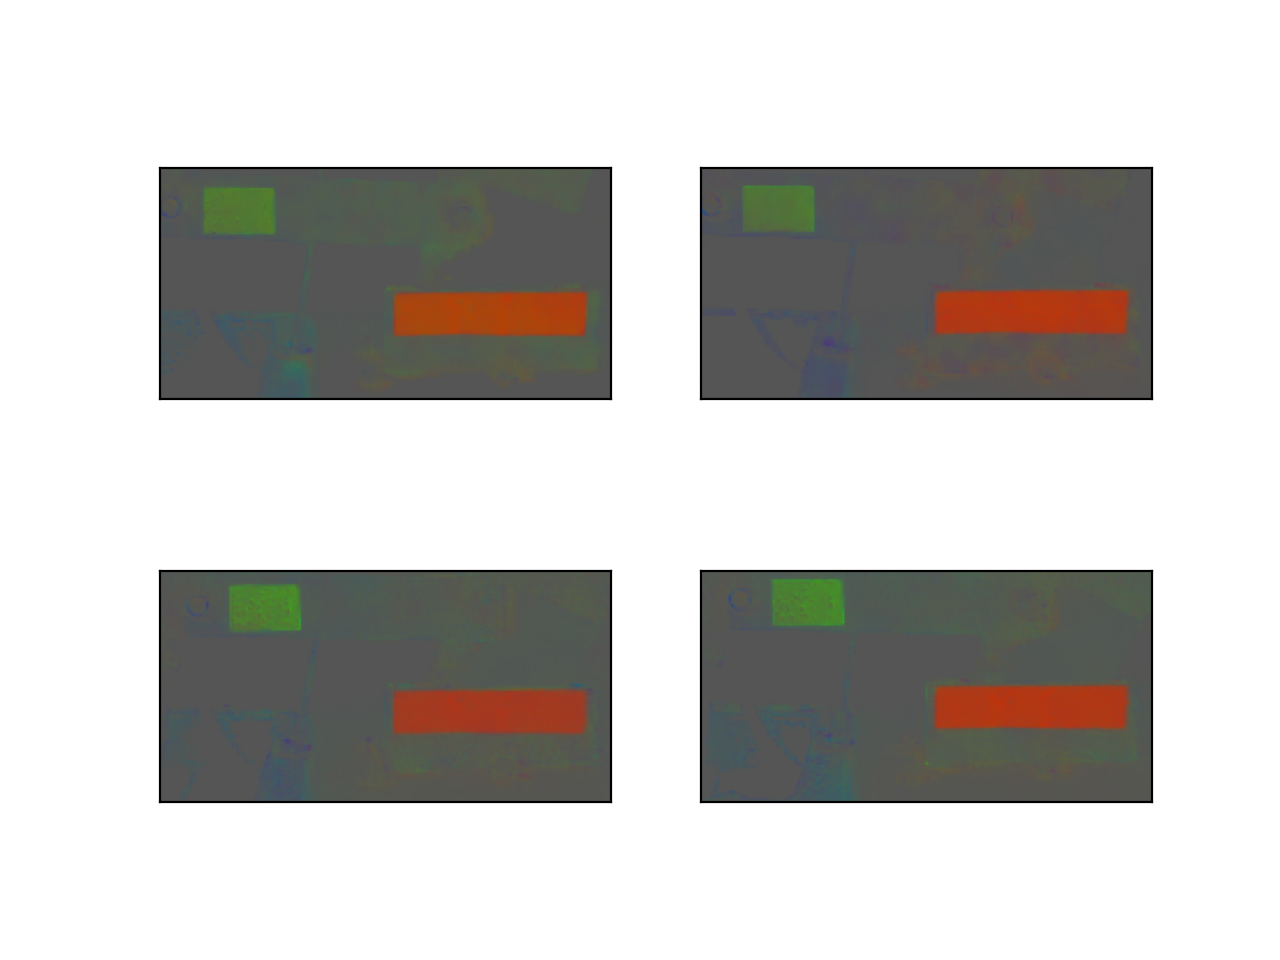

In [16]:
## perform rg chromacity on all images and plot the results
features, noStripe = norm_to_target(False,pixcels,False,False) # perform only rg chromacity on all pixcles to create feature array
plotSamples(features[:,:,sample,:]*255, False, False, False, False) # plot the resulting images

In [17]:
## Perfrom kmeans clustering using fais on the features to find the stripes
I, kmeans, stripeColour =  faissCluster(features, stripeFrac, stripe_startNo, it, False) # perform faiss clustering looking for stripe
stripeColour = get_colour_cosine(kmeans, [255,169,0]) # find the cluster label with the centre closest to the target colour using cosine distance

clustering with 1

Sampling a subset of 256 / 103467000 for training
Clustering 256 points in 3D to 1 clusters, redo 1 times, 10 iterations
  Preprocessing in 1.82 s
Cluster Min was 1.0 s, search 0.00 s): objective=3.64326 imbalance=1.000 nsplit=0       

clustering with 2


Sampling a subset of 512 / 103467000 for training
Clustering 512 points in 3D to 2 clusters, redo 1 times, 10 iterations
  Preprocessing in 1.80 s
Cluster Min was 0.07875509099519654s): objective=1.33431 imbalance=1.759 nsplit=0       

clustering with 3


Sampling a subset of 768 / 103467000 for training
Clustering 768 points in 3D to 3 clusters, redo 1 times, 10 iterations
  Preprocessing in 1.79 s
Cluster Min was 0.07889329931282438s): objective=1.5562 imbalance=2.003 nsplit=0        

clustering with 4


Sampling a subset of 1024 / 103467000 for training
Clustering 1024 points in 3D to 4 clusters, redo 1 times, 10 iterations
  Preprocessing in 1.79 s
Cluster Min was 1000s, search 0.00 s): objective=1.09111 imba

<IPython.core.display.Javascript object>


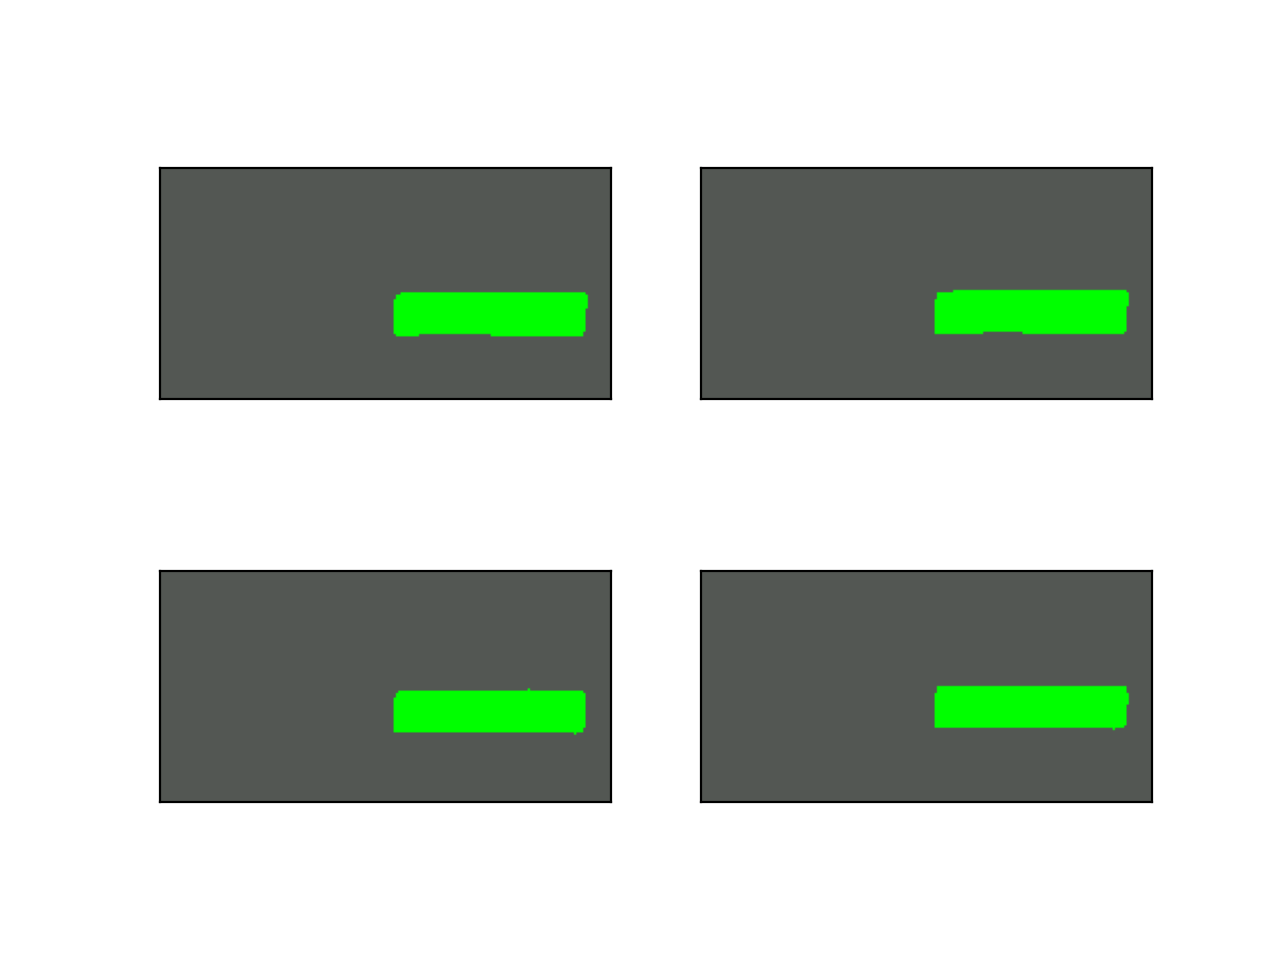

In [18]:
imgArr = clus2Image(I, kmeans.centroids[:,0:3], {stripeColour[0]: [0,1,0]}, False)  # convert labels and centroids to image arrays
imgArr = np.reshape(imgArr, orig_shape) # reshape for plotting
plotSamples(imgArr[:,:,sample,:]*255, False, False, False, False) # plot resulting clsuters

used Last pic mean [110.0, 42.0, 42.0] for image number 1528
used Last pic mean [112.0, 58.0, 42.0] for image number 1843
used Last pic mean [162.0, 76.0, 52.0] for image number 3722


<IPython.core.display.Javascript object>


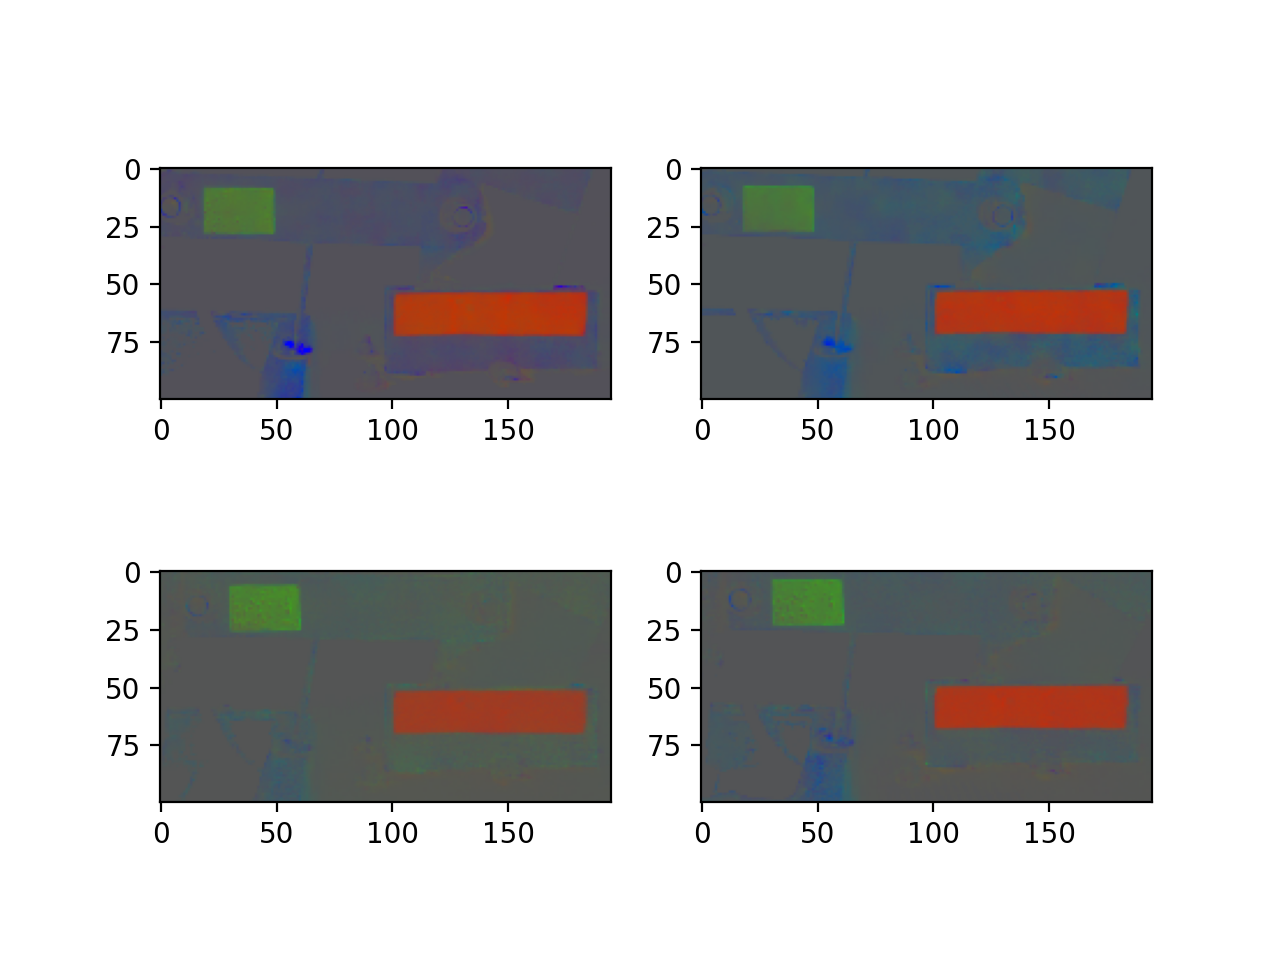

In [19]:
## use know stripe locations to normalise colour accross data set using mean translate and then rgb chormisation
features, noStripe = norm_to_target(I,pixcels,stripeColour, True) # renormalise with colour adjustment
plotSamples(features[:,:,sample,:]*255, True, False, False, False) # plot normalised images

In [20]:
## recluster using improved features
I, kmeans, stripeColour =  faissCluster(features, stripeFrac, 1, it, noStripe/l) # rerun kmeans on normalised pixcels

clustering with 1


Sampling a subset of 256 / 103467000 for training
Clustering 256 points in 3D to 1 clusters, redo 1 times, 10 iterations
  Preprocessing in 1.82 s
Cluster Min was 1.0 s, search 0.00 s): objective=5.38732 imbalance=1.000 nsplit=0       

clustering with 2


Sampling a subset of 512 / 103467000 for training
Clustering 512 points in 3D to 2 clusters, redo 1 times, 10 iterations
  Preprocessing in 1.80 s
Cluster Min was 0.0858677452714392 s): objective=4.86422 imbalance=1.739 nsplit=0       

clustering with 3


Sampling a subset of 768 / 103467000 for training
Clustering 768 points in 3D to 3 clusters, redo 1 times, 10 iterations
  Preprocessing in 1.80 s
Cluster Min was 0.08223036330424194s): objective=4.38489 imbalance=2.120 nsplit=0       

clustering with 4


Sampling a subset of 1024 / 103467000 for training
Clustering 1024 points in 3D to 4 clusters, redo 1 times, 10 iterations
  Preprocessing in 1.80 s
Cluster Min was 0.07543462166681164s): objective=4.28504 imb

In [21]:
## check the cluster found as the stripe is closest in colour to what was expected
stripeColour_cosine = get_colour_cosine(kmeans, [255,169,0]) # find stripe colour using cosine distance
if stripeColour_cosine != stripeColour:
    print("Error, the cluster found for stripes is inconsitent")

<IPython.core.display.Javascript object>


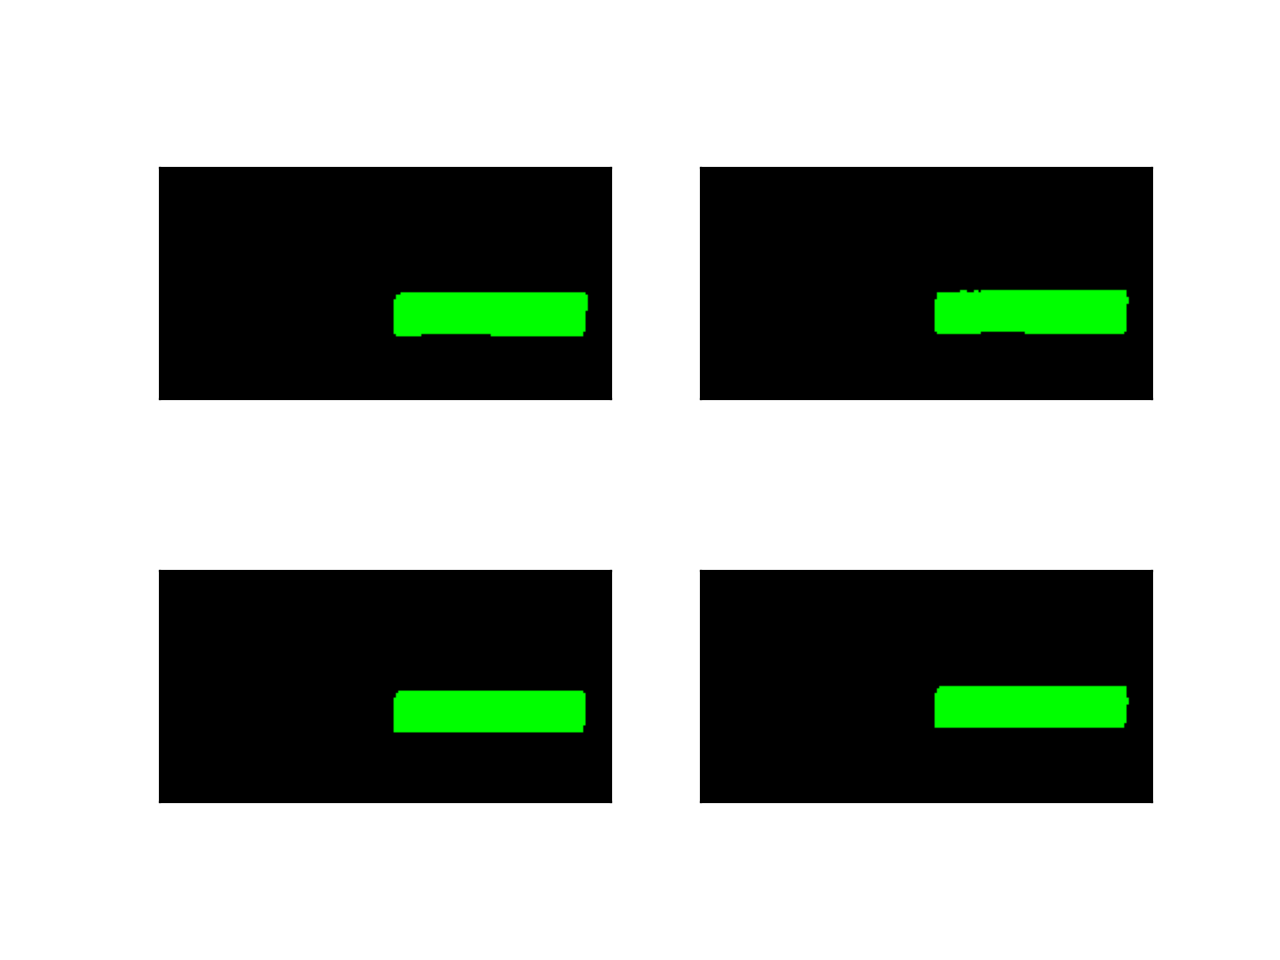

In [22]:
## plot final stripe clusters
imgArr = clus2Image(I, kmeans.centroids[:,0:3], {stripeColour[0]: [0,255,0]}, False) # convert cluster labels and centres to image array with stripe cluster highlighted green
imgArr = np.reshape(imgArr, orig_shape) # reshape to suit plotting
plotSamples(imgArr[:,:,sample,:], False, False, False, False) # plot samples

In [26]:
## use PCA to find the long edge of the stripe and project coordinates onto this axis and find statistical properties
stripe_coords = np.array(np.where(np.reshape(I, (h,w,l)) == stripeColour)) # get stripe locations from reshaped labels array
Vh, stripe_coords_clean = find_rotation(stripe_coords) # use find rotation to find the roation matrix to make x axis align with the longest edge
stripeStats_df, stripeLength = cluster_length(stripe_coords_clean, Vh) # use cluster_length to build the stripe stats df and find the length of the stripe in pixcels
stripeStats_df = getMiddle(stripeStats_df, stripeLength, "stripe") # use getMiddle to find the middle of the stripes and update stripes df

calculating cluster length for image #5305of5306


In [27]:
## recluster using faiss kmeans to find the dot clusters
I, kmeans, dotColour =  faissCluster(features, dotFrac, stripe_startNo, it, noStripe/l)

clustering with 1


Sampling a subset of 256 / 103467000 for training
Clustering 256 points in 3D to 1 clusters, redo 1 times, 10 iterations
  Preprocessing in 1.82 s
Cluster Min was 1.0 s, search 0.00 s): objective=5.38732 imbalance=1.000 nsplit=0       

clustering with 2


Sampling a subset of 512 / 103467000 for training
Clustering 512 points in 3D to 2 clusters, redo 1 times, 10 iterations
  Preprocessing in 1.80 s
Cluster Min was 0.0858677452714392 s): objective=4.86422 imbalance=1.739 nsplit=0       

clustering with 3


Sampling a subset of 768 / 103467000 for training
Clustering 768 points in 3D to 3 clusters, redo 1 times, 10 iterations
  Preprocessing in 1.81 s
Cluster Min was 0.08223036330424194s): objective=4.38489 imbalance=2.120 nsplit=0       

clustering with 4


Sampling a subset of 1024 / 103467000 for training
Clustering 1024 points in 3D to 4 clusters, redo 1 times, 10 iterations
  Preprocessing in 1.80 s
Cluster Min was 0.07543462166681164s): objective=4.28504 imb

In [28]:
## check the cluster found as dot colour is the closest to the expected colour
dotColour_cosine = get_colour_cosine(kmeans, [0,256,0]) # find dot colour using cosine distance
if dotColour_cosine != dotColour:
    print("Error, the cluster found for dots is inconsitent")

Error, the cluster found for dots is inconsitent


In [30]:
dotColour = dotColour_cosine

<IPython.core.display.Javascript object>


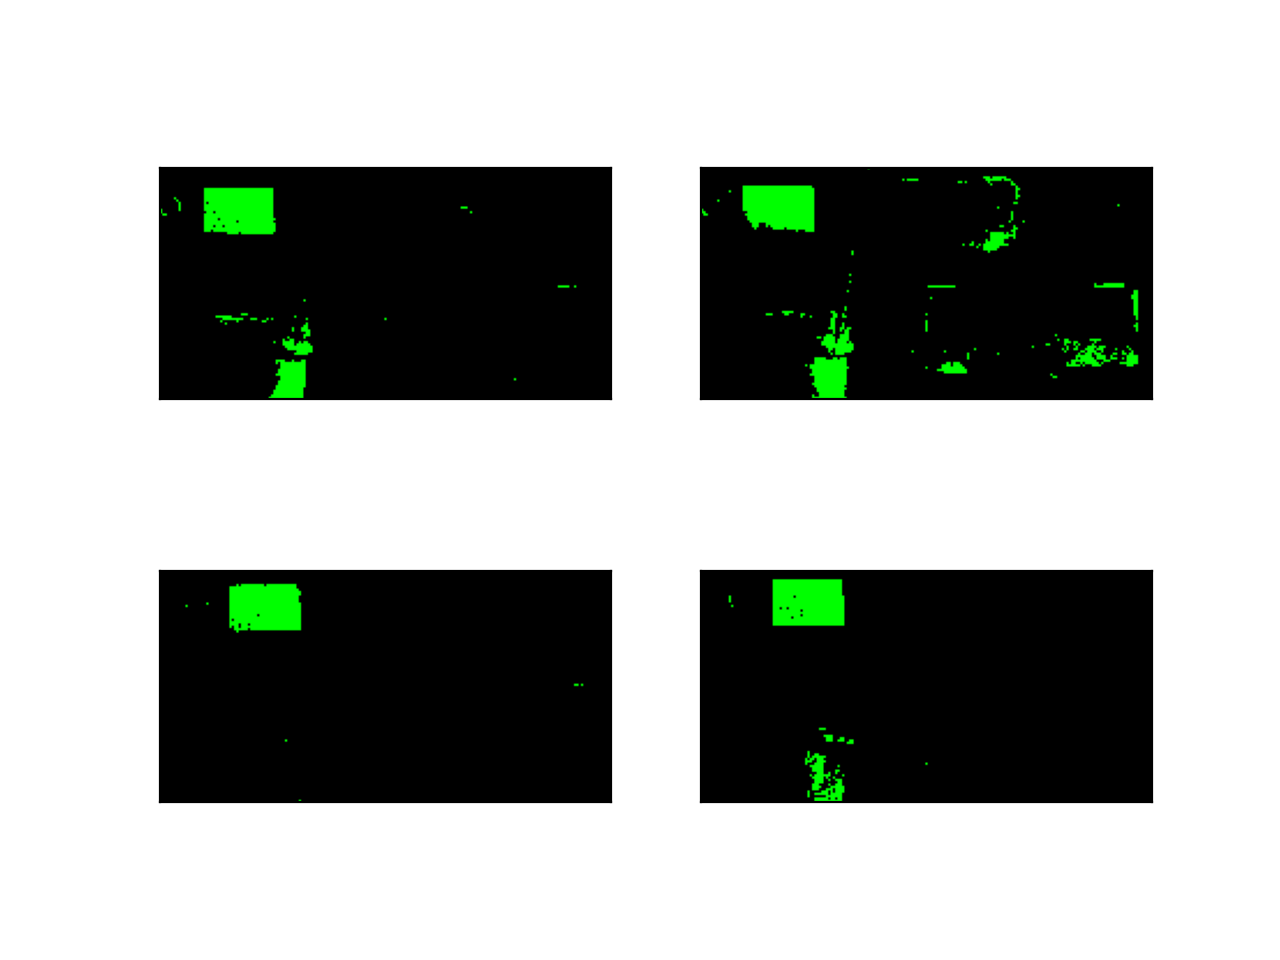

In [31]:
imgArr = clus2Image(I, kmeans.centroids[:,0:3], {dotColour[0]: [0,255,0]}, False) # use cluster labels and centroids to build image arrays
imgArr = np.reshape(imgArr, orig_shape) # reshape to suit plotting
plotSamples(imgArr[:,:,sample,:], False, False, False, False) # plot sample image

In [32]:
dot_coords = np.array(np.where(np.reshape(I, (h,w,l)) == dotColour)) # get stripe locations from reshaped labels array
Vdot, dot_coords_clean = find_rotation(dot_coords) # find the cleaned dot cordinates and the rotation matrix
dotStats_df, dotLength = cluster_length(dot_coords_clean , Vh) # use cluster_length to find the legth if the dot and the dot stats_df
dotStats_df = getMiddle(dotStats_df, dotLength, "dot") # use get middle to find the midle of the dots and append it to the dotStats_df

calculating cluster length for image #5305of5306


<IPython.core.display.Javascript object>


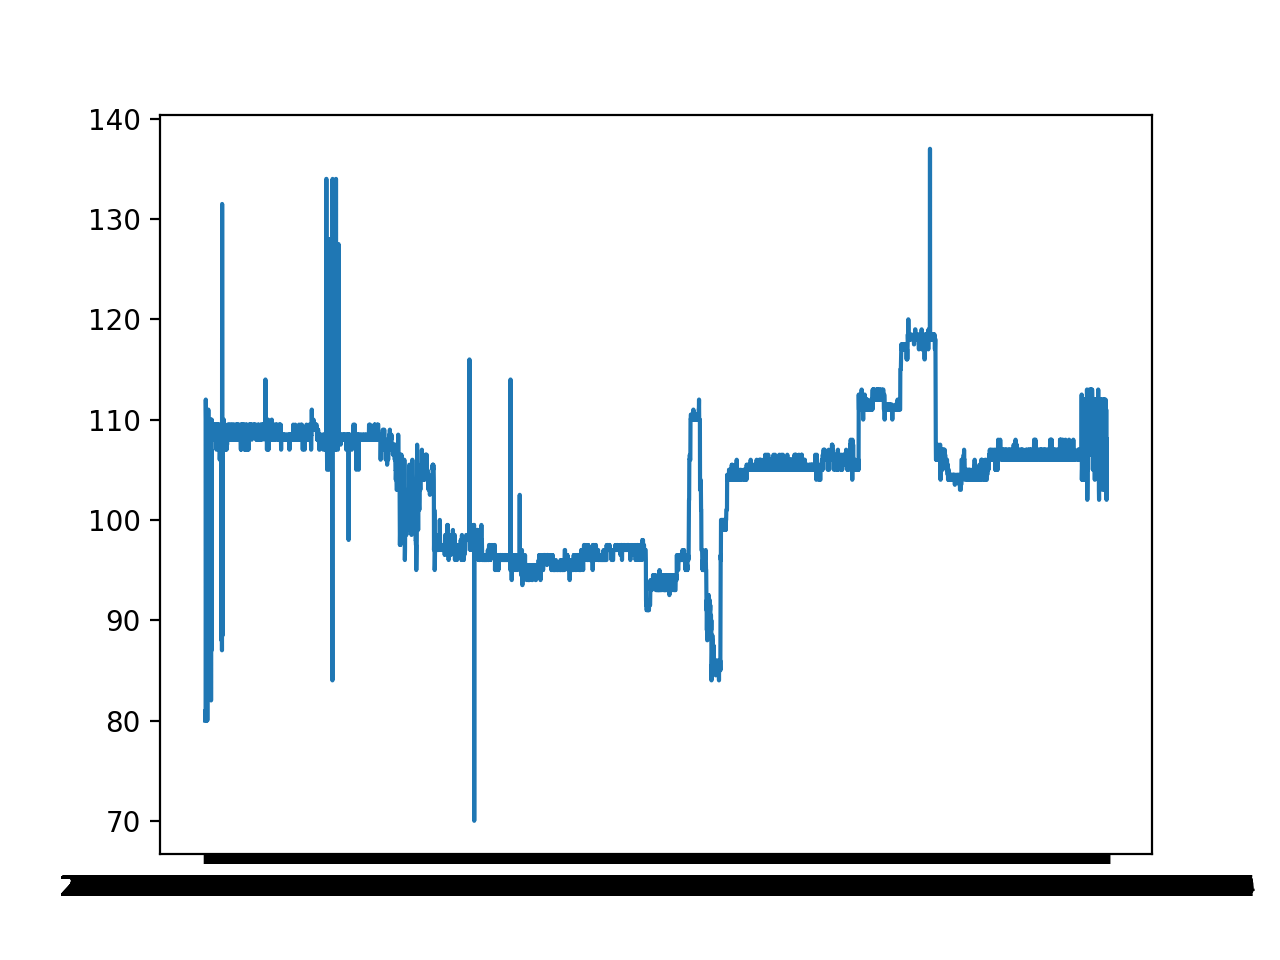

In [33]:
stats_df = pd.merge(stripeStats_df, dotStats_df, on = 'image') # merge the 2 stats df on image for easy computation
measure = stats_df['stripe'] - stats_df['dot'] # find difference between the centre of the stripe and the centre of the dot
dataOut = pd.DataFrame({'time':timeStamp, 'measure':measure}) # build new data frame with just time and the measurement
dataOut = dataOut.sort_values('time') # sort values by time
plt.close()
plt.plot(dataOut.time,dataOut.measure) # create a time series plot of the measured values

<IPython.core.display.Javascript object>


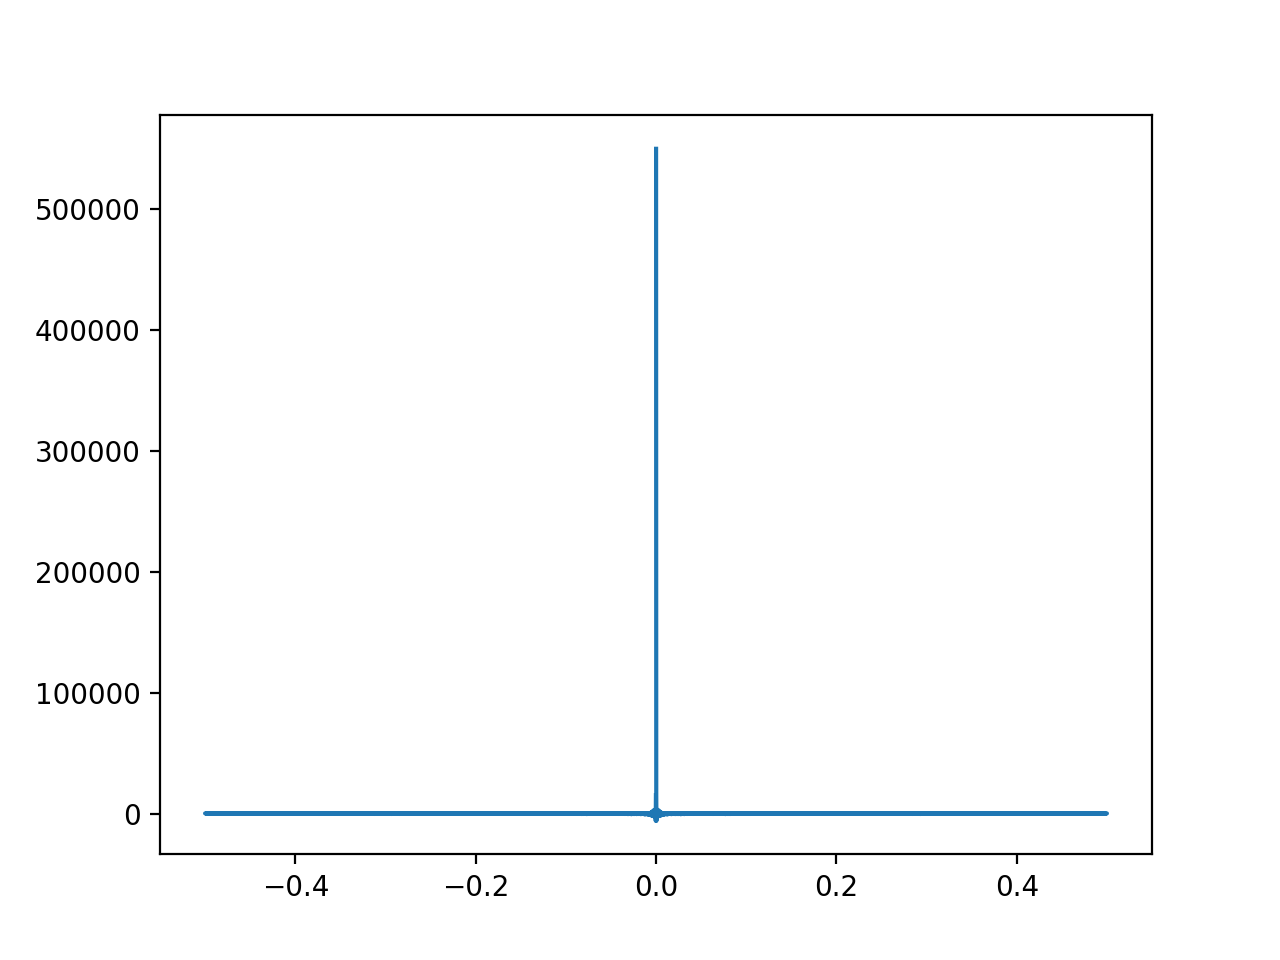

/home/veering/anaconda3/envs/visualStringpot/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


In [34]:
## use FFT to clean outliers from data
dataOut.dropna(axis=0, how='any', inplace=True) # drop NA's
x = np.array(list(dataOut.measure)) # create array of measurements
y =  np.array(list(dataOut.time)) # create array of time stamps
xf = fft(x) # fft x
yf = fftfreq(len(y),1) # find freqencies
plt.close()
plt.plot(yf,xf) # plot fourier transformed data vs frequency

<IPython.core.display.Javascript object>


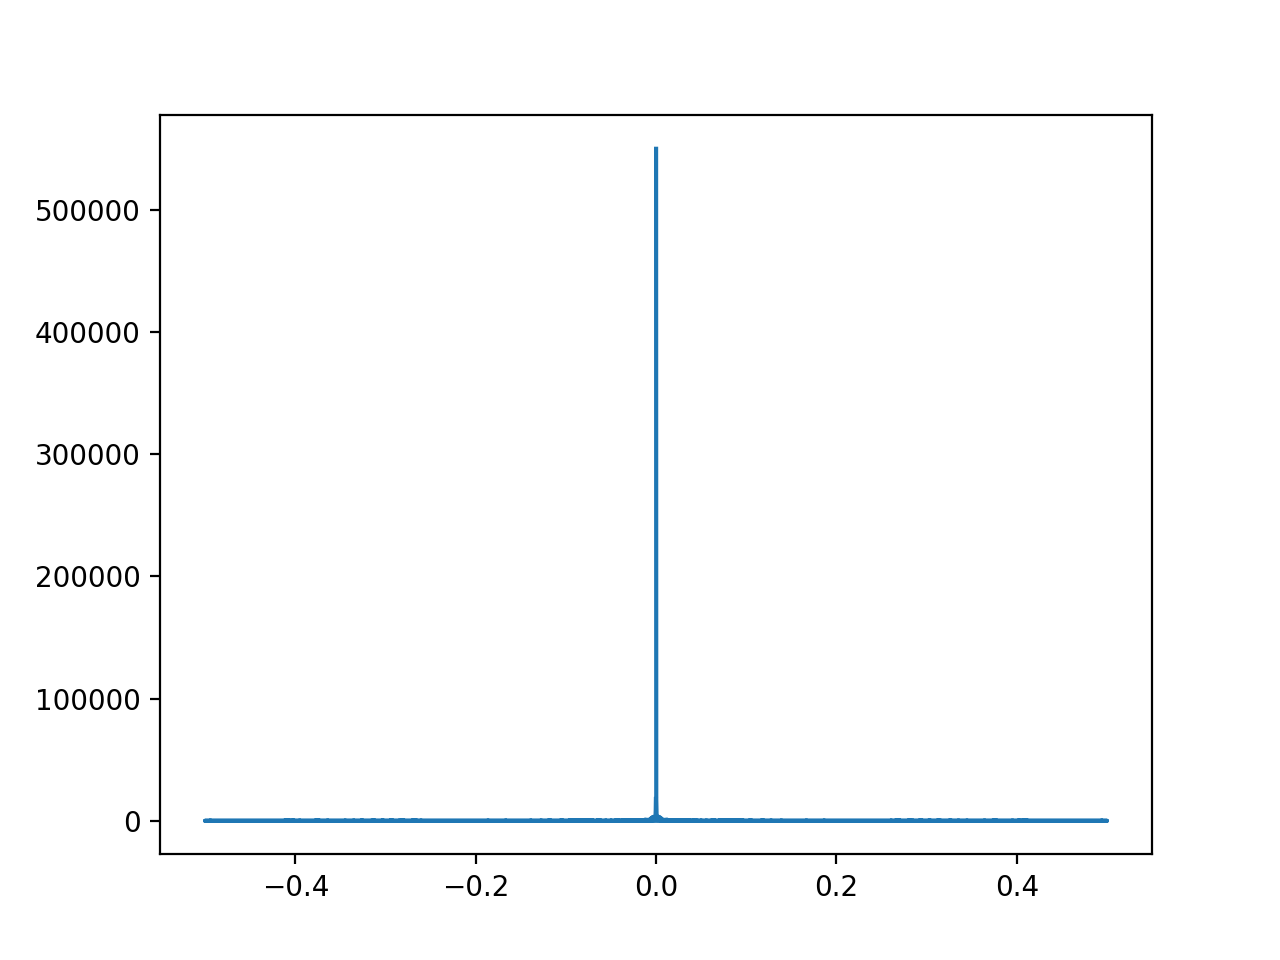

In [41]:
xf_abs = np.abs(xf) # find absolute values of fft
indicies = xf_abs > 250 # find indicies where freqency is greater
xf_clean = indicies * xf # clean data using indicies filter
plt.close()
plt.plot(yf, np.abs(xf_clean)) # plot cleaned fourier transformed data vs frequency

<IPython.core.display.Javascript object>


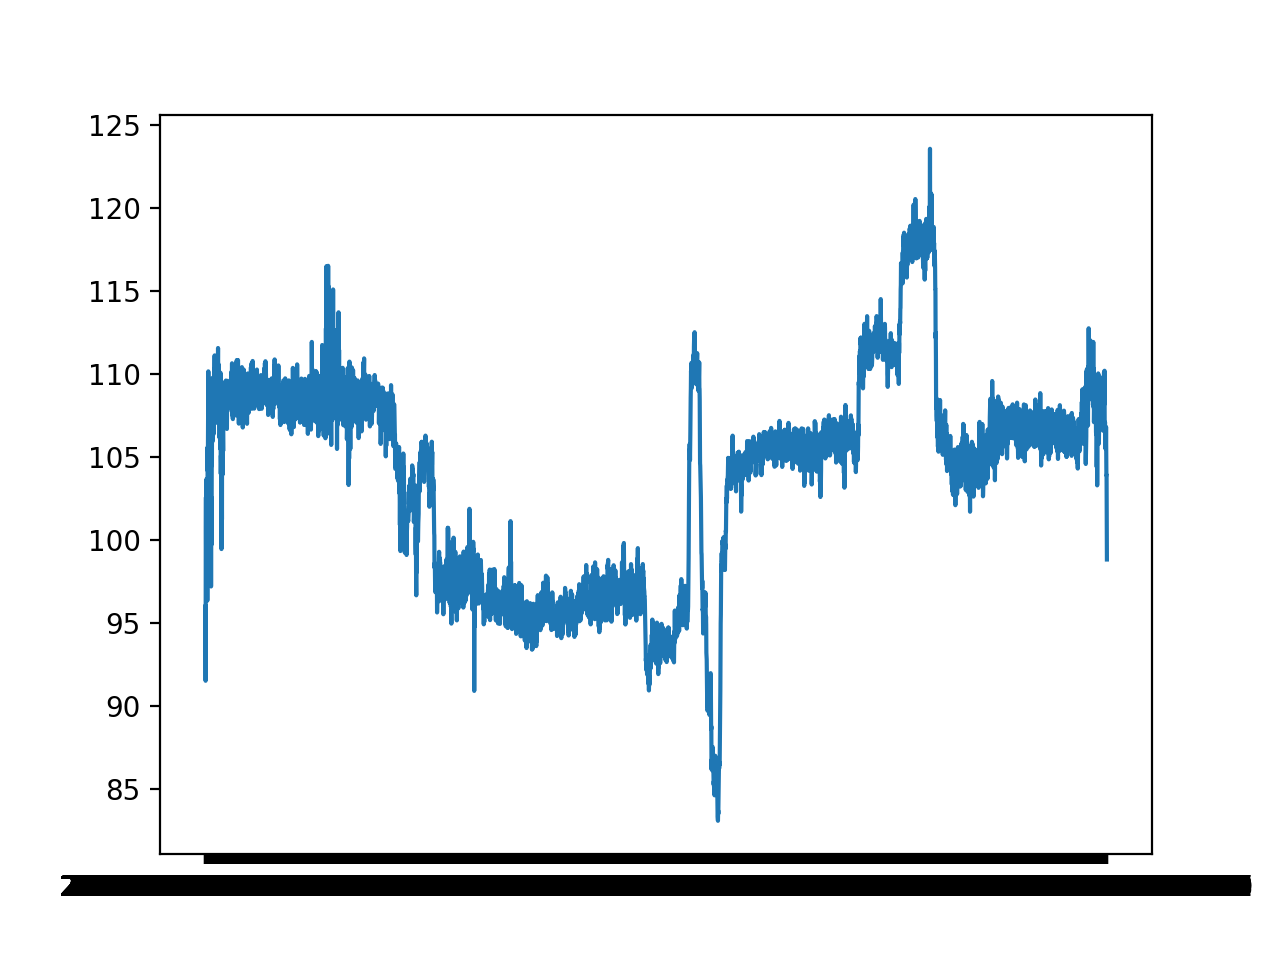

/home/veering/anaconda3/envs/visualStringpot/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


In [42]:
new_f_clean = ifft(xf_clean) # inverse FFT for the cleaned values
plt.close()
plt.plot(y, new_f_clean) # plot the new time series

/home/veering/anaconda3/envs/visualStringpot/lib/python3.9/site-packages/pandas/core/window/rolling.py:348: ComplexWarning: Casting complex values to real discards the imaginary part
  values = ensure_float64(values)


<IPython.core.display.Javascript object>


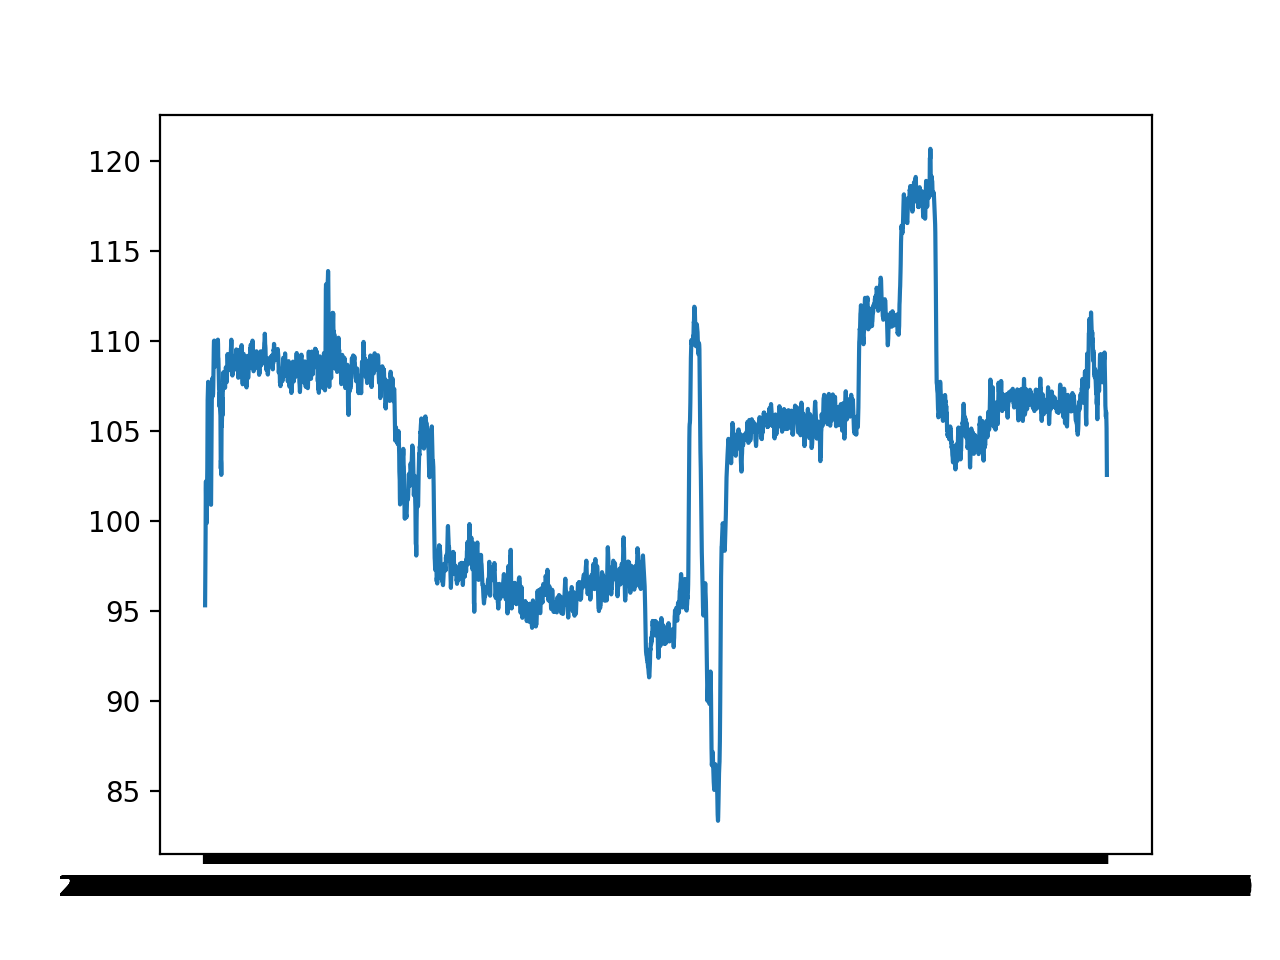

In [51]:
## use residual from rolling mean and standard deviation to smooth time serries data
avg = pd.Series(new_f_clean) # create a pandas series of all measurements from the FFT cleaning
avg = avg.rolling(5).mean() # calculate the rolling 5 second mean
std = pd.Series(new_f_clean) # create a pandas series of all measurements from the FFT cleaning
std = std.rolling(5).std() # calculate the rolling 5 second standard deviation
residuals = pd.Series(new_f_clean) - avg



plt.close()
plt.plot(y, avg)

<IPython.core.display.Javascript object>


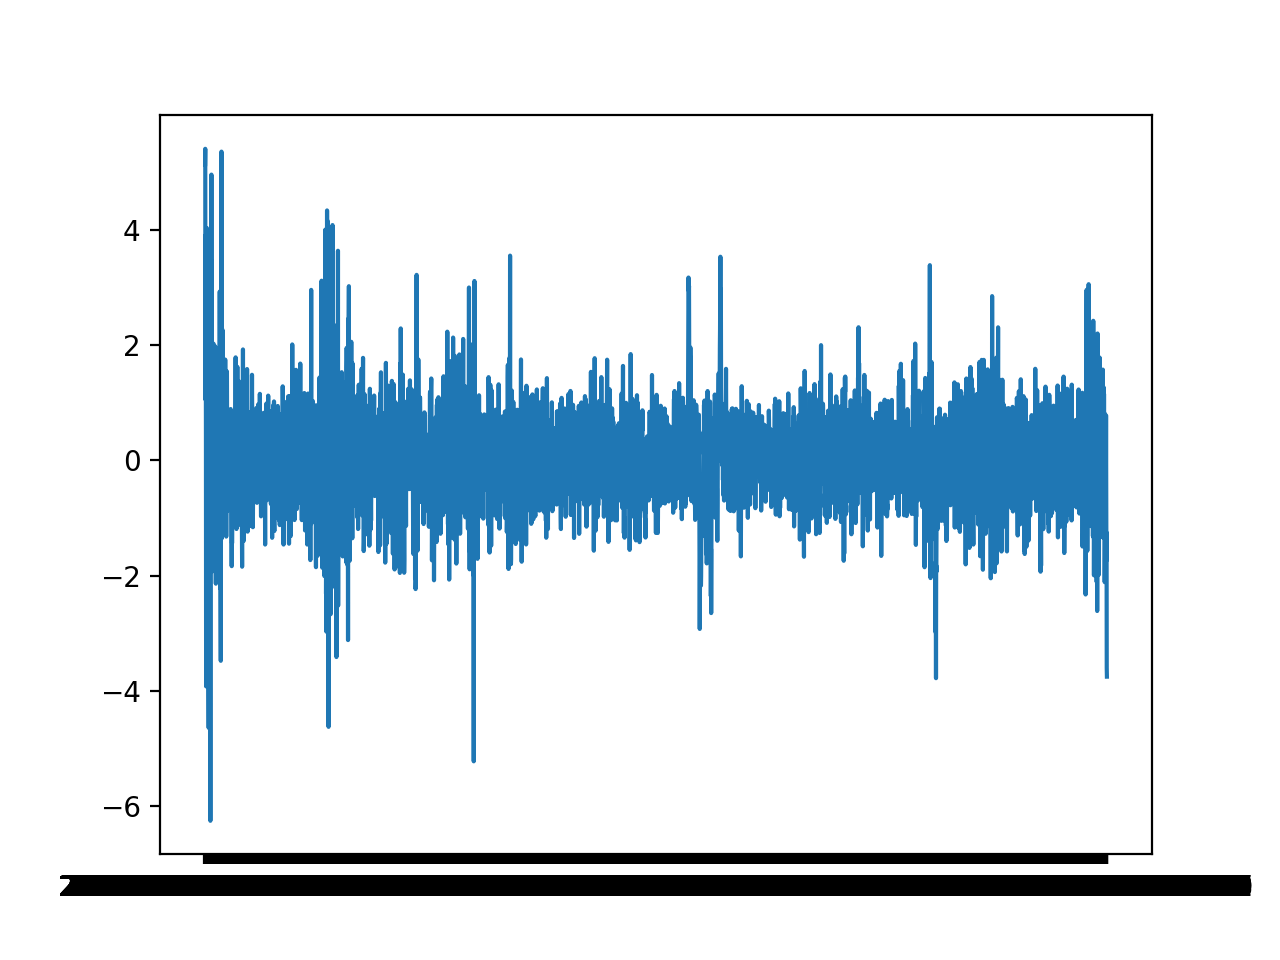

/home/veering/anaconda3/envs/visualStringpot/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


In [52]:
plt.close()
plt.plot(y, residuals)

<IPython.core.display.Javascript object>


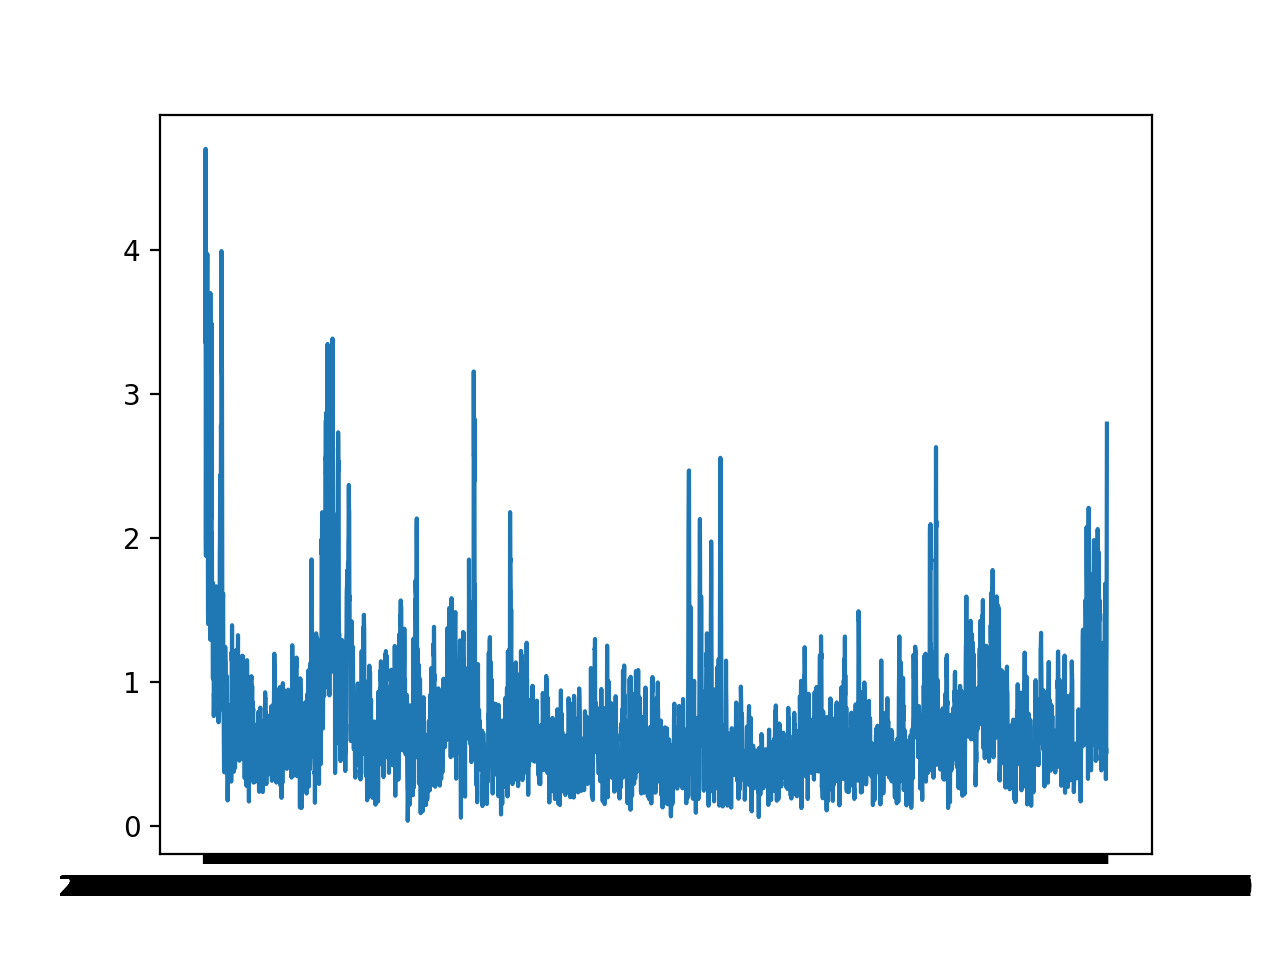

In [53]:
plt.close()
plt.plot(y, std)

In [60]:
residuals = residuals > (std *2)

In [61]:
len(np.where(residuals == True)[0])

347

In [74]:
test = []
for i in range(0,len(residuals)):
    if residuals[i]:
        test.append(avg[i])
    
    else:
        test.append(avg[i])
    

<IPython.core.display.Javascript object>


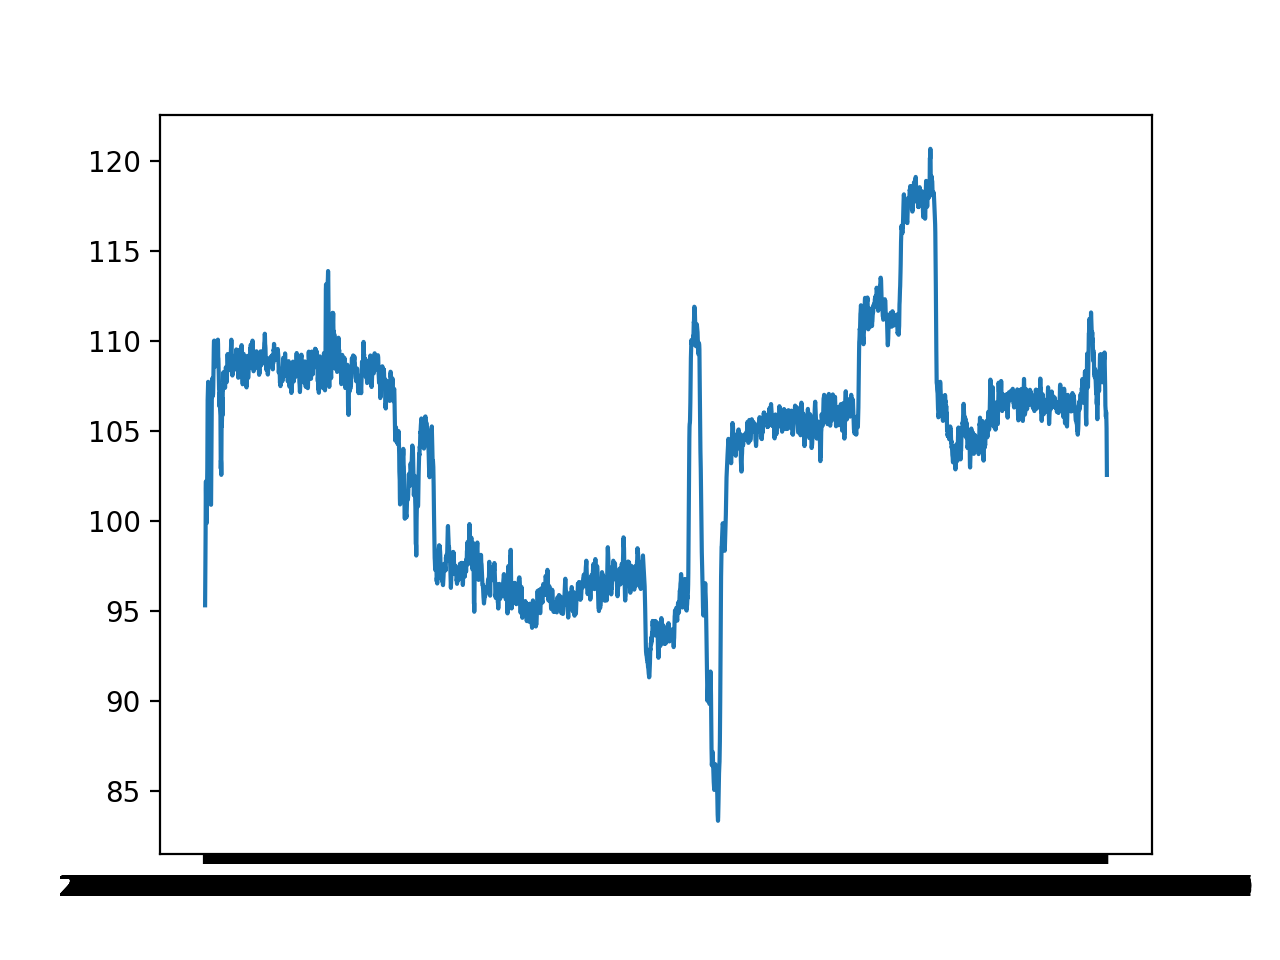

In [75]:
plt.close()
plt.plot(y, test)

In [76]:
## define known geometry
knownLength = -87 # known length of the stripe, negative if measure should get larger when dot is closer to stripe
offset = -127.5 # known zero offset

In [77]:
test = test * (knownLength/stripeLength) + offset

TypeError: can't multiply sequence by non-int of type 'numpy.float64'

In [70]:
stripeLength

82.0